In [14]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing import image


In [2]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, df, batch_size = 32, dim=(32,32), n_channels=3,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, idx):
        'Generate one batch of data'
        # Generate indexes of the batch
        batch_indices = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Find list of IDs
        df_batch = self.df.iloc[batch_indices,:]
        df_batch = df_batch.reset_index()
        # Generate data
        X, y = self.__data_generation(df_batch)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, df_batch):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i in range(len(df_batch)):
            img = image.load_img(df_batch.loc[i,'path'], target_size=self.dim)
            X[i] = image.img_to_array(img)
            y[i] = df_batch.loc[i,'label']

        return X, y

In [3]:
def gather_dataset_info(root_path):
    """
    Walks through the root_path and gathers paths of all files and their respective classes.
    
    Parameters:
    - root_path: The root directory containing class-wise subdirectories.
    
    Returns:
    - df: DataFrame with columns 'path' and 'label'.
    """
    data = {'path': [], 'label': []}

    carpetas = os.listdir(root_path)
    # Walk through each directory in the root_path
    for carpeta in carpetas:
        # Assuming that directory names in root_path are class names
        dirpath = os.path.join(root_path, carpeta, "images")
        files = os.listdir(dirpath)
        # print(dirpath)
        for filename in files:
            # Ensure we're only picking up image files (you can add more extensions if needed)
            # print(os.path.join(dirpath, filename))
            data['path'].append(os.path.join(dirpath, filename))
            data['label'].append(os.path.basename(carpeta))  # Class label is the name of the parent directory

    df = pd.DataFrame(data)
    return df

def map_labels_to_numbers(df, label_column):
    """
    Maps text labels in a DataFrame to numbers.

    Parameters:
    - df: The input DataFrame.
    - label_column: The column name containing the text labels.

    Returns:
    - df: DataFrame with labels mapped to numbers.
    - label_map: Dictionary mapping original labels to numbers.
    """
    # Create a mapping from label to number
    unique_labels = df[label_column].unique()
    label_map = {label: idx for idx, label in enumerate(unique_labels)}
    
    # Apply the mapping to the DataFrame
    df[label_column] = df[label_column].map(label_map)
    
    return df, label_map

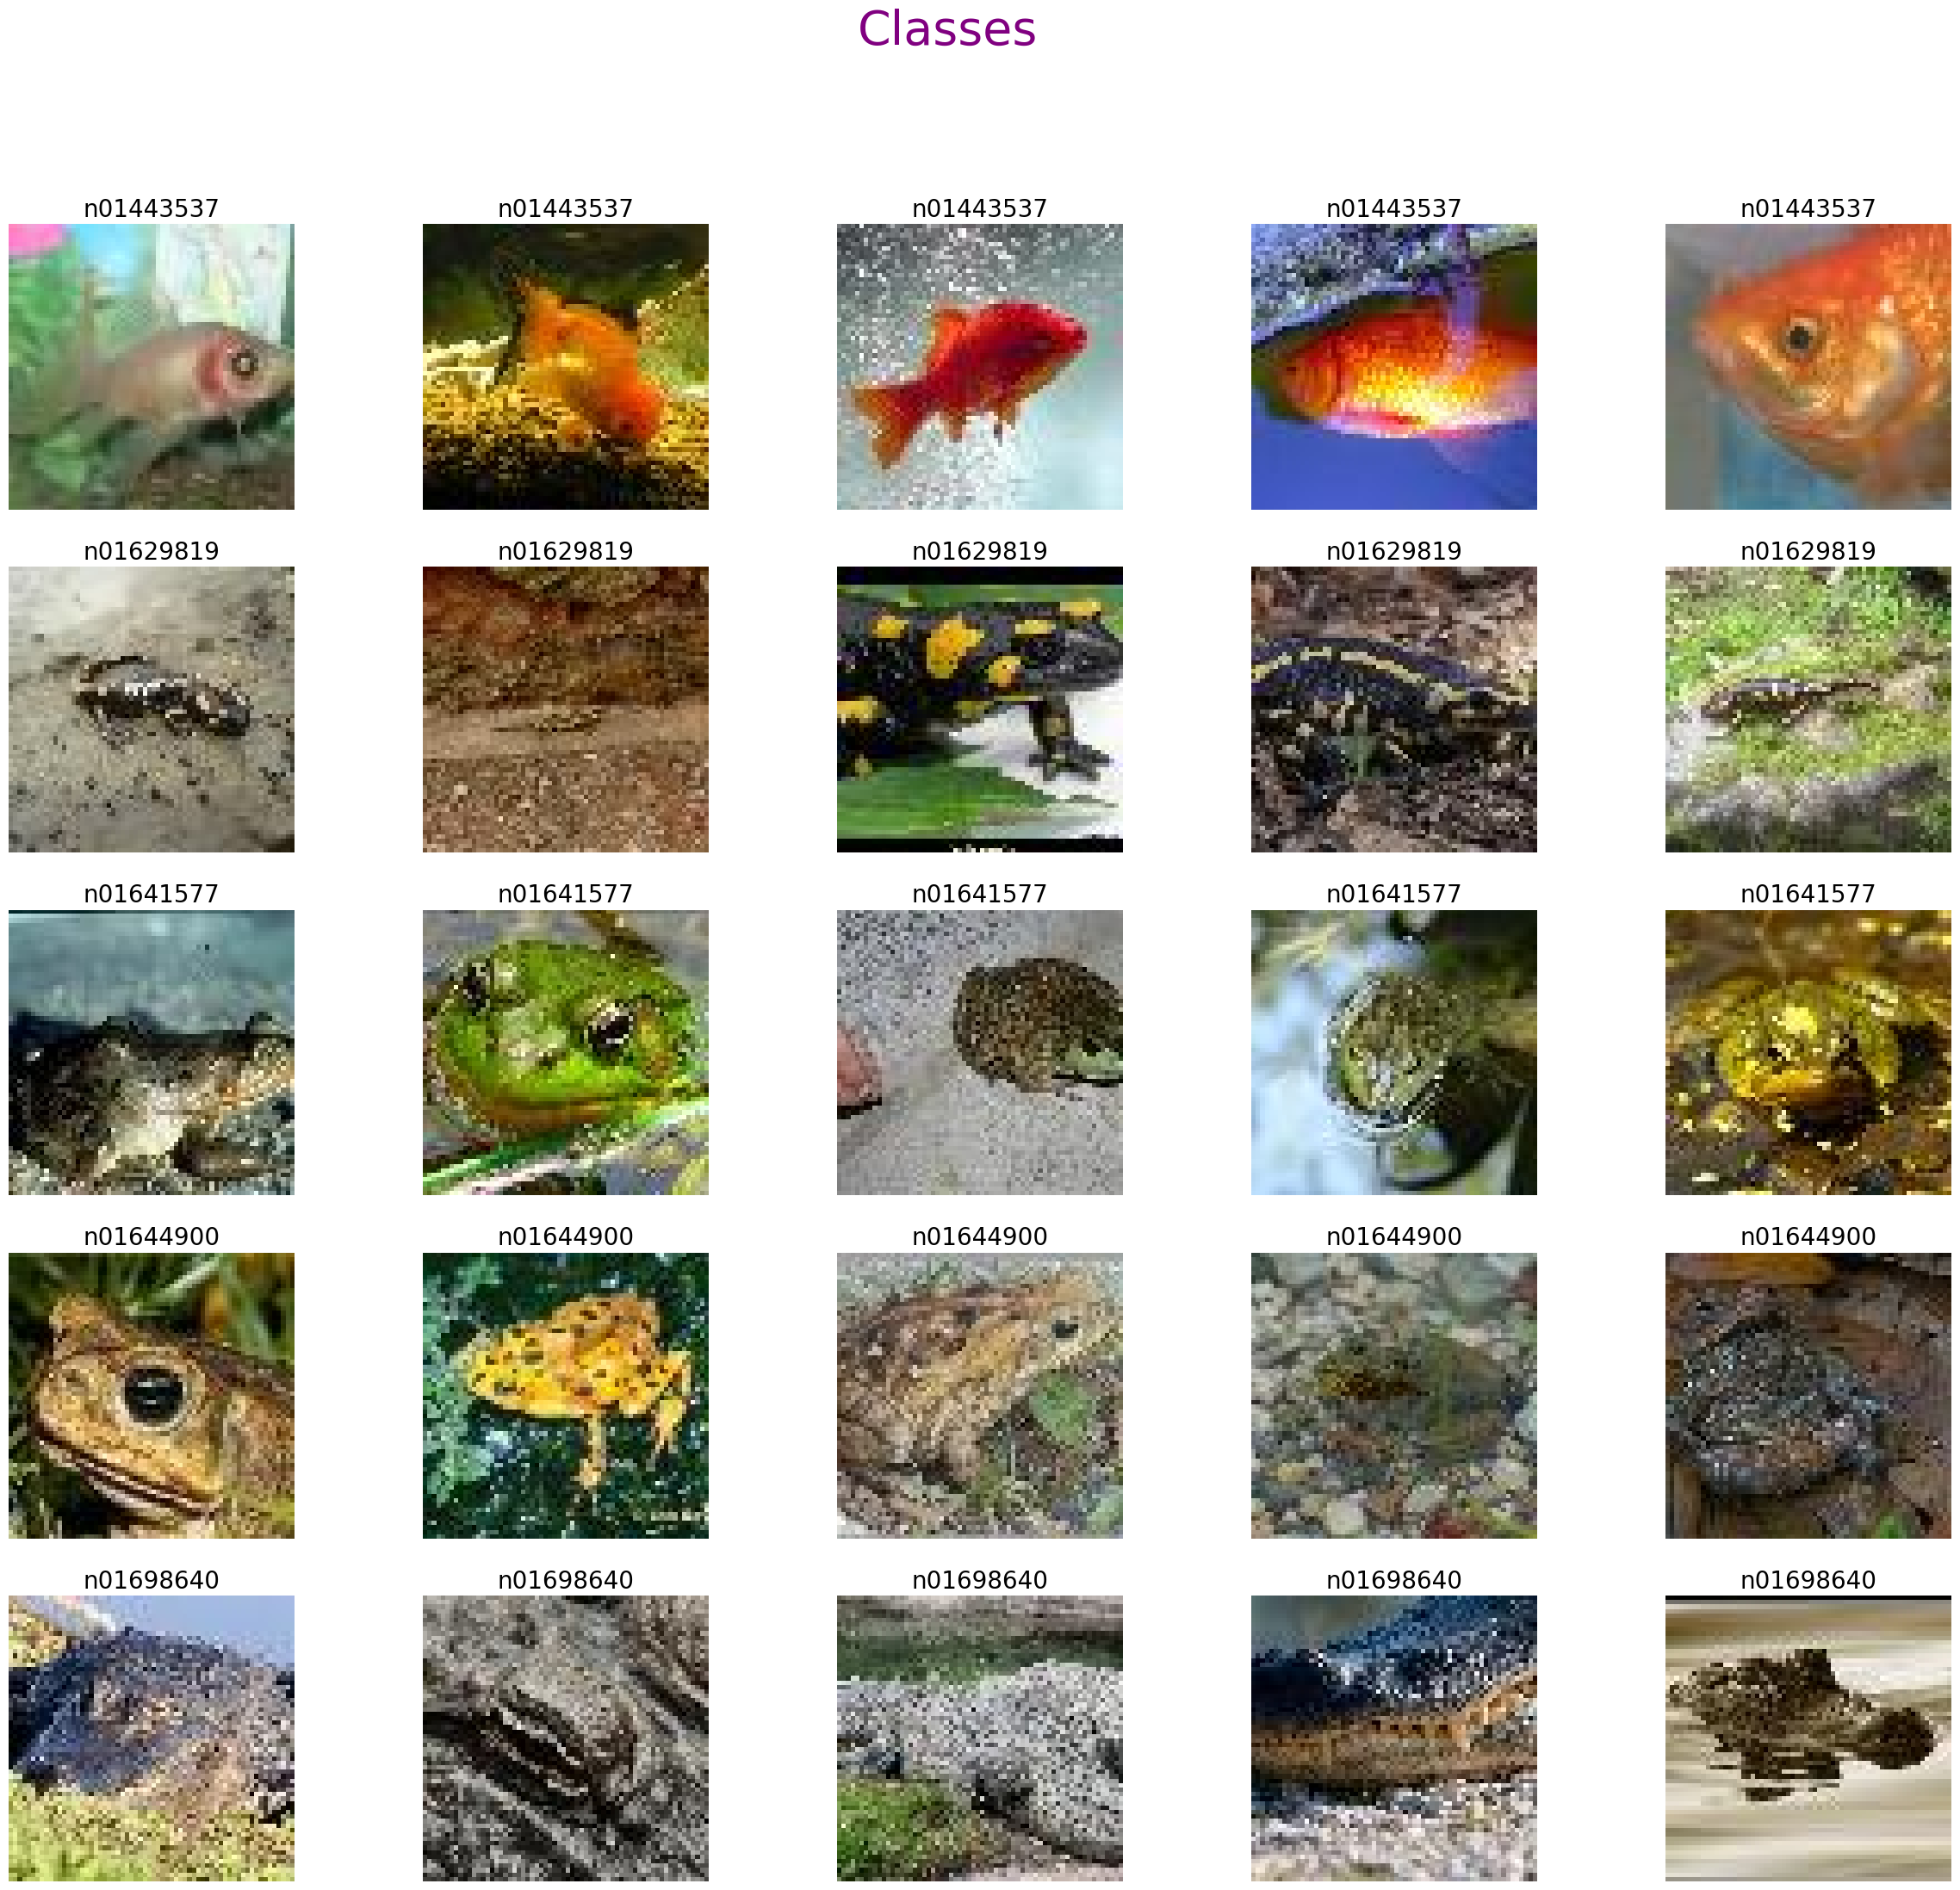

In [4]:
ppath = r"C:\Users\Juan M\Maestria\semestre2\aprendizaje_automatico\Talleres\tiny-imagenet-200"
class_names = os.listdir(os.path.join(ppath, "train"))

fig, ax = plt.subplots(5, 5, figsize=(30, 25))
fig.suptitle('Classes', color='purple', fontsize=40)

for ax_row, class_name in zip(ax, class_names[:6]):
    im_src = os.path.join(ppath, 'train', class_name + '/images')
    file_names = os.listdir(im_src)
    
    for ax_col, file_name in zip(ax_row, file_names[:5]):
        im_src_file = os.path.join(im_src, file_name)
        image = plt.imread(im_src_file)
        ax_col.axis("off")
        ax_col.imshow(image)
        ax_col.set_title(class_name, fontsize=20)

plt.show()

In [9]:
# Create the data generator
batch_size = 32
image_size = (150, 150)
num_channels = 3


ppath = r"C:\Users\Juan M\Maestria\semestre2\aprendizaje_automatico\Talleres\tiny-imagenet-200"
train_path = os.path.join(ppath, "train")
train_df = gather_dataset_info(train_path)
train_df, label_map = map_labels_to_numbers(train_df, 'label')

In [10]:
train_df.head()

,path,label
0,C:\Users\Juan M\Maestria\semestre2\aprendizaje...,0
1,C:\Users\Juan M\Maestria\semestre2\aprendizaje...,0
2,C:\Users\Juan M\Maestria\semestre2\aprendizaje...,0
3,C:\Users\Juan M\Maestria\semestre2\aprendizaje...,0
4,C:\Users\Juan M\Maestria\semestre2\aprendizaje...,0


In [11]:
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['label'])

print("Training DataFrame:")
print(train_df['label'].value_counts())

print("\nTesting DataFrame:")
print(val_df['label'].value_counts())

train_data_gen = DataGenerator(df = train_df, batch_size = batch_size, dim = image_size, n_channels = num_channels)
val_data_gen = DataGenerator(val_df, batch_size, image_size, num_channels)

Training DataFrame:
136    400
73     400
56     400
81     400
50     400
      ... 
185    400
180    400
184    400
158    400
3      400
Name: label, Length: 200, dtype: int64

Testing DataFrame:
55     100
142    100
145    100
120    100
131    100
      ... 
107    100
106    100
53     100
94     100
47     100
Name: label, Length: 200, dtype: int64


In [12]:
#Now lets create a simple classifier 
def ClassModel(input_shape, num_classes):
    model = models.Sequential([
        # Normalizing the data to [0, 1]
        layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape),
        
        # Vectorizing (flattening) the image
        layers.Flatten(),
        
        # Fully connected layers
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Output layer for multi-class classification (no activation since we're using logits)
        layers.Dense(num_classes)
    ])
    
    return model

# Assuming images of shape (150, 150, 3) and 5 classes for demonstration
input_shape = (150, 150, 3)
num_classes = len(label_map)
model = ClassModel(input_shape, num_classes)

# Compile the model with cross-entropy from logits
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 flatten (Flatten)           (None, 67500)             0         
                                                                 
 dense (Dense)               (None, 128)               8640128   
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                        

In [15]:
history = model.fit(train_data_gen,
                    epochs = 10,  # Number of times to iterate over the entire dataset
                    validation_data= val_data_gen)  # Optional validation data

Epoch 1/10
2500/2500 [==============================] - 352s 140ms/step - loss: 5.1656 - accuracy: 0.0187 - val_loss: 4.9490 - val_accuracy: 0.0294
Epoch 2/10
2500/2500 [==============================] - 269s 108ms/step - loss: 4.9603 - accuracy: 0.0309 - val_loss: 4.8346 - val_accuracy: 0.0460
Epoch 3/10
2500/2500 [==============================] - 272s 109ms/step - loss: 4.9178 - accuracy: 0.0335 - val_loss: 4.7977 - val_accuracy: 0.0503
Epoch 4/10
2500/2500 [==============================] - 275s 110ms/step - loss: 4.8935 - accuracy: 0.0367 - val_loss: 4.7883 - val_accuracy: 0.0534
Epoch 5/10
2500/2500 [==============================] - 271s 108ms/step - loss: 4.8858 - accuracy: 0.0366 - val_loss: 4.7527 - val_accuracy: 0.0569
Epoch 6/10
2500/2500 [==============================] - 266s 107ms/step - loss: 4.8694 - accuracy: 0.0375 - val_loss: 4.7683 - val_accuracy: 0.0531
Epoch 7/10
2500/2500 [==============================] - 290s 116ms/step - loss: 4.8512 - accuracy: 0.0399 - val_

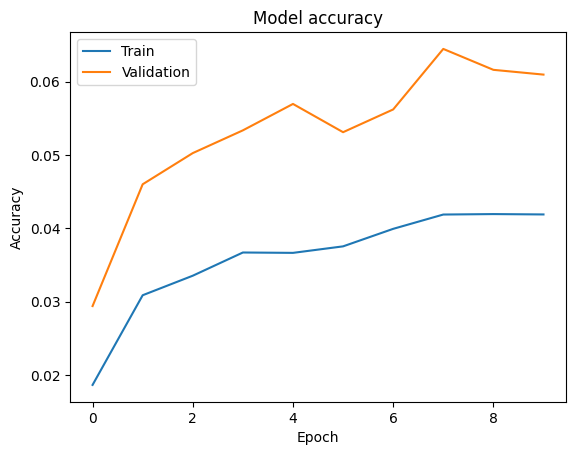

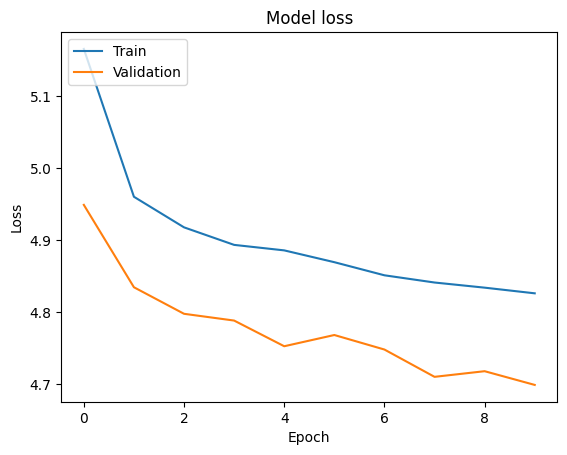

In [16]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()